# Hospital Length of Stay

In this solution template, we demonstrate how you could train machine learning models in SQL database in order to predict how long a newly admitted patient would stay in a hospital. 

Being able to predict future resource demand accurately and quickly is important in many scenarios. In this case, knowing how long a patient will likely to stay in the hospital can help us make an informed decision on resource allocation, as described earlier in [this article](https://blogs.msdn.microsoft.com/mlserver/2017/02/15/predicting-hospital-length-of-stay-los-using-sql-server-2016-with-r-services/). 

We have previously presented [the solution using SQL server 2016 with R](https://gallery.cortanaintelligence.com/Solution/Predicting-Length-of-Stay-in-Hospitals-1), which involves using RevoScaleR to process the data and train predictive models that are then operationalized in the SQL server machine. Data scientits can do their work entirely in R and save time by doing all the computation at the SQL Server machine in parallel and not limited by the memory of their client computer. 

This notebook covers the same idea but with Python and more focus on the codes. In SQL Server 2017, you can use Python to takes advantage of the power of SQL Server and revoscalepy. The tables are all stored in a SQL Server, and most of the computations are done by loading chunks of data in-memory instead of the whole dataset. 

We will go through the following: 

 * **Step 0: Packages and Compute Contexts**
 * **Step 1: Processing and Cleaning**
 * **Step 2: Feature Engineering**
 * **Step 3: Training and Evaluating a Random Forest, Boosted Trees, Fast Trees, and a Neural Network**
 
Check out [Microsoft Machine Learning Server](https://docs.microsoft.com/en-us/machine-learning-server/) for more details. You can use the search bar on the left to see definitions of the functions used in this template. 

## Step 0: Packages and Compute Contexts

In this step, we set up the connection string to access a SQL Server Database and load the necessary packages. 

We will be using machine learning algorithms from both [revoscalepy](https://docs.microsoft.com/en-us/sql/advanced-analytics/python/what-is-revoscalepy) and [microsoftml](https://docs.microsoft.com/en-us/machine-learning-server/python-reference/microsoftml/microsoftml-package) Python libraries.  We encapsulated some code insides `length_of_stay_utils.py` to ease the reading of this template. You can see the code in the repository. 

In [1]:
import os, sys
from numpy import mean
from math import sqrt
import pyodbc
from pandas import to_numeric, DataFrame

import revoscalepy as rp 
import microsoftml as mml
import length_of_stay_utils as utils

We are creating a database called "Hospital" on our local SQL server. We will use this database to store the data, all the intermediate results, and the models and their prediction results. 

In [2]:
# Choose a database name and create it. 
db = "Hospital"

# Connect to the master database only to create a new database. 
master_connection_string = "Driver=SQL Server;Server=localhost;Database=master;Trusted_Connection=Yes"

# Create a database if doesn't already exits yet. 
utils.create_database(master_connection_string, db)

## Step 1: Uploading and inspecting the data

In this step, we will 

* Upload the dataset to SQL so that we can perform computations in the SQL compute context. 
* Inspect the data to see if there is any preprocessing that needs to be done. 

In [3]:
# Set the compute context to local. 
localcc = rp.RxLocalSeq()
rp.rx_set_compute_context(localcc)

We will read in the data stored on our local machine and upload it to the SQL server for later use. See the description on the data [here](https://microsoft.github.io/r-server-hospital-length-of-stay/input_data.html)

In [ ]:
# Point to the input data set while specifying the types of the variables in each column.
col_type_info = utils.get_los_col_info() 
LoS_text = rp.RxTextData(file = os.path.join("..\\Data", "LengthOfStay.csv"), column_info=col_type_info)

# Upload the data to the SQL server and call the table "LengthOfStay". 
connection_string = "Driver=SQL Server;Server=localhost;Database=Hospital;Trusted_Connection=Yes"
LengthOfStay_sql = rp.RxSqlServerData(table = "LengthOfStay", connection_string = connection_string)
rp.rx_data_step(input_data = LoS_text, output_file = LengthOfStay_sql, overwrite = True)

Now that we have the data in the SQL server, we can then use RxSQLServerData to establish a data source and get data from the SQL server. Here, we are simply getting the variable names in the data. 

In [ ]:
# First, get the names and types of the variables to be treated.
data_sql = rp.RxSqlServerData(table = "LengthOfStay", connection_string = connection_string, stringsAsFactors = True)
colnames = rp.rx_get_var_names(data_sql)

# Get the names of the variables that actually have missing values. Assumption: no NA in eid, lengthofstay, or dates. 
variables = [x for x in colnames if x not in ["eid", "lengthofstay", "vdate", "discharged"]]
f = "+".join(variables)
summary = rp.rx_summary(formula = f, data = data_sql, by_term = True).summary_data_frame

In [6]:
var_with_NA = summary[summary["MissingObs"] > 0]
missing = False if var_with_NA.empty else True  
print(missing)

False


`rx_summary` gives us the mean, standard deviation, as well as the number of missing observation in each column that's a continuous variable. We see that we have no missing observations so we will continue to the next step. 

## Step 2: Feature Engineering

In this step, we will:

-  Standardize the continuous variables (Z-score).
-  Create the variable number_of_issues: the number of preidentified medical conditions.


In [ ]:
# Continuous variables that we care about. 
measures = ["hematocrit", "neutrophils", "sodium", "glucose", "bloodureanitro", 
            "creatinine", "bmi", "pulse", "respiration"]

# Get the mean and standard deviation those variables
stats = ["Mean", "StdDev"]
f = "+".join(measures)
summary_stats = rp.rx_summary(formula = f, data = data_sql, by_term = True, summary_stats = stats).summary_data_frame

In [8]:
print(summary_stats)

             Name        Mean     StdDev
0      hematocrit   11.975939   2.031792
1     neutrophils   10.177455   5.353131
2          sodium  137.891397   2.999669
3         glucose  141.963384  29.992996
4  bloodureanitro   14.097185  12.952454
5      creatinine    1.099350   0.200262
6             bmi   29.805759   2.003769
7           pulse   73.444720  11.644555
8     respiration    6.493768   0.568473


With the summary statistics, we can then calculate the Z score of each continuous variable. We also want to add another column that summarizes how many health issues each patient has in their record. We can do both of these operations on our data by putting them in one transform function. `rx_data_step` can then transform the data as it reads data from the input data source and stores the result to the output data source. 

In [9]:
def standardize(data, context):
    for n, row in summary_stats.iterrows():
        data[[row["Name"]]] = (data[[row["Name"]]] - row["Mean"])/row["StdDev"]
    return data

def calculate_number_of_issues(data, context):
    issues = ["hemo", "dialysisrenalendstage", "asthma", "irondef", "pneum", "substancedependence", 
              "psychologicaldisordermajor", "depress", "psychother", "fibrosisandother", "malnutrition"]
    data["number_of_issues"] = sum([to_numeric(data[issue]) for issue in issues])
    return data

# Combine transform functions into one overarching transform.
def transform(dataset, context):
    data = standardize(dataset, context)
    data = calculate_number_of_issues(data, context)
    return data

In [ ]:
# Drop the LoS view in case the SQL Stored Procedure was executed in the same database before.
utils.drop_view("LoS", connection_string)

# Standardize the cleaned table by wrapping it up in rxDataStep. 
LoS_sql = rp.RxSqlServerData(table = "LoS", connection_string = connection_string)
rp.rx_data_step(input_data = data_sql, output_file = LoS_sql, overwrite = True, transform_function = transform)

# Convert number_of_issues to character with a SQL query.
utils.alter_column("LoS", "number_of_issues", "varchar(2)", connection_string)
utils.alter_column("LoS", "lengthofstay", "float", connection_string)

## Step 3: Training and Evaluating the Models

In this step we:

**1.** Split randomly the data set LoS into a training (LoS_train) and a testing (LoS_test) set.
 
**2.** Train a Random Forest, Boosted Trees, Fast Trees, and Neural Network models on LoS_train using tools from revoscalepy and microsoftml, and save them to SQL. 

**3.** Score the models on LoS_test in SQL compute context. 

**Input:** Data set LoS.

**Output:** Random forest, Boosted Trees, Fast Trees, and Neural Network models saved to SQL and performance metrics.  

Here we will train various machine learning models. In order to evaluate them, we will split our data into 70% training and the rest of 30% for testing. 

In [ ]:
# Point to the SQL table with the data set for modeling. Strings will be converted to factors.
LoS = rp.RxSqlServerData(table = "LoS", connection_string = connection_string, strings_as_factors = True)

# Randomly split the data into a 70% training set and a 30% testing set. 
LoS_train, LoS_test = utils.make_train_test_data(LoS, 70, connection_string, "eid", "LoS", "Train_Id")

Here we create the formula that we will use to create different machine learning models to predict the length of stay. 

In [ ]:
# Create the formula for training a decision forest model. 
variables_all = rp.rx_get_var_names(LoS)
variables_to_remove = ["eid", "vdate", "discharged", "facid"]
formula = utils.create_formula("lengthofstay", variables_all, variables_to_remove)

Here we define a function that stores a machine learning model to a table in our database. `write_rts_model` is currently only supported in the local compute context so we will set compute context to local, whereas training of the models is done in the SQL compute context. Besides the key to identify the model, you can also specify the version of the model to better manage your machine learning workflow. 

In [13]:
# The compute context is set to local in order to export the model.
rp.rx_set_compute_context(localcc)

# Real-time scoring models will be serialized and stored in the same table and be retrieved by their keys. 
def write_rts_model(model, key, connection_string):
    RTS_odbc = rp.RxOdbcData(connection_string, table="RTS")
    serialized_model = rp.rx_serialize_model(model, realtime_scoring_only=True)
    rp.rx_write_object(RTS_odbc, key=key, value=serialized_model, serialize=False, compress=None, overwrite=True)

With the formula and the training set, we can now create four different models. Training these models is done in the SQL compute context. This means that you can leverage the compute power of your SQL server to train these models without pulling data to your local computer. You can then save the model in the SQL database to use it later in the scoring.  


### Random Forest (revoscalepy)

In [ ]:
# Train a random decision forest in a SQL compute context. It's better to explicitly set 'max_num_bins' and 'min_split'.
sql = rp.RxInSqlServer(connection_string=connection_string)
num_rows = utils.get_num_rows("Train_Id", connection_string)
forest_model = rp.rx_dforest(formula = formula, data=LoS_train, max_num_bins=int(sqrt(num_rows)), 
                             min_split=int(sqrt(num_rows)),compute_context=sql)

# Save the Random Forest in SQL. 
write_rts_model(forest_model, "RF", connection_string)

### Boosted Tree Model (revoscalepy)

In [ ]:
# Train a boosted trees model. It's better to explicitly set 'max_num_bins' and 'min_split'. 
boosted_model = rp.rx_btrees(formula=formula, data=LoS_train, loss_function="gaussian", 
                             max_num_bins=int(sqrt(num_rows)), min_split=int(sqrt(num_rows)), compute_context=sql) 
# Save the model in SQL. 
write_rts_model(boosted_model, "GBT", connection_string)

### Fast tree model  (microsoftml)

In [ ]:
# Train the Fast Trees model.
fast_model = mml.rx_fast_trees(formula=formula, data=LoS_train, method="regression", compute_context=sql)
# Save the Fast Trees in SQL. 
write_rts_model(fast_model, "FT", connection_string)

### Neural network model (microsoftml)

In [ ]:
# Train the Neural Network model.
NN_model = mml.rx_neural_network(formula=formula, data=LoS_train, method="regression", compute_context=sql)
# Save the model. 
write_rts_model(NN_model, "NN", connection_string)

## Scoring 

We will now evaluate each of the models we have trained by making predictions on the testing data and then calculate some measures of errors.

In [18]:
rp.rx_set_compute_context(sql)

def model_scoring(table_name, connection_str, model, test_data, predict_func):
    """ Make prediction on the test_data using the model and store the result to `table_name` """
    prediction_sql = rp.RxSqlServerData(table = table_name,
                                        strings_as_factors = True,
                                        connection_string = connection_str)
    predict_func(model, data = test_data, output_data = prediction_sql,
              type = "response", extra_vars_to_write = ["lengthofstay", "eid"], overwrite = True)
    return prediction_sql

### Random Forest scoring

In [ ]:
# Make predictions, then store it in "Forest_Prediction"
forest_prediction_sql = model_scoring("Forest_Prediction", connection_string, forest_model, LoS_test, rp.rx_predict)

# Compute the performance metrics of the model.
forest_prediction = rp.rx_import(input_data = forest_prediction_sql)
forest_metrics = utils.evaluate_model(observed = forest_prediction['lengthofstay'],
                                predicted = forest_prediction['lengthofstay_Pred'],
                                model = "RF")

### Boosted trees

In [ ]:
# Make Predictions then store it in "Boosted_Prediction"
boosted_prediction_sql = model_scoring("Boosted_Prediction", connection_string, boosted_model, LoS_test, rp.rx_predict)

# Compute the performance metrics of the model.
boosted_prediction = rp.rx_import(input_data = boosted_prediction_sql)
boosted_metrics = utils.evaluate_model(observed = boosted_prediction['lengthofstay'],
                                 predicted = boosted_prediction['lengthofstay_Pred'],
                                 model = "GBT")

### Fast trees

In [ ]:
# Make Predictions, then write them to "Fast_Prediction".
fast_prediction_sql = model_scoring("Fast_Prediction", connection_string, fast_model, LoS_test, mml.rx_predict)

# Compute the performance metrics of the model.
fast_prediction = rp.rx_import(input_data=fast_prediction_sql)
fast_metrics = utils.evaluate_model(observed=fast_prediction['lengthofstay'], predicted=fast_prediction['Score'], model="FT")


### Neural network

In [ ]:
# Make Predictions, then write them to a table.
NN_prediction_sql = model_scoring("NN_Prediction", connection_string, NN_model, LoS_test, mml.rx_predict)

# Compute the performance metrics of the model.
NN_prediction = rp.rx_import(input_data=NN_prediction_sql)
NN_metrics = utils.evaluate_model(observed=NN_prediction['lengthofstay'], predicted=NN_prediction['Score'], model="NN")

## Looking at predictions
We can now use the predictions made from the model to estimate the length of stay for each patient. Here we can peak at the actual length of stay versus the predicted length of stay from the fast tree model. 

In [ ]:
# Write to Master Predictions Table (LoS_Predictions)
query = """SELECT LengthOfStay.eid, LoS.lengthofstay,
               CONVERT(DATE, CONVERT(DATETIME, LengthOfStay.vdate, 110) + CAST(ROUND(Score, 0) as int), 110) as discharged_Pred,
               CAST(ROUND(Score, 0) as int) as lengthofstay_Pred
         FROM LoS JOIN Fast_Prediction ON LoS.eid = Fast_Prediction.eid JOIN LengthOfStay ON LoS.eid = LengthOfStay.eid;"""
results_sql = rp.RxSqlServerData(sql_query=query, connection_string=connection_string)
results_sql.head()

## Model comparision

With the error metrics of the four models, we can then compare how well each model performs. This would depend on how you wish to compare different models. There are also other parameters you can use in the model training functions that we omitted for simplicity but you can use to further refine the models. 

In [25]:
models = [forest_metrics, boosted_metrics, fast_metrics, NN_metrics]
summary = utils.create_summary_dataframe(models)
summary = summary.set_index("model_name")
summary

,coefficient_of_determination,mean_absolute_error,relative_absolute_error,relative_squared_error,root_mean_squared_error
model_name,,,,,
RF,0.845799,0.677762,0.353710,0.154201,0.925846
GBT,0.374156,1.496279,0.780877,0.625844,1.865215
FT,0.968310,0.309405,0.161472,0.031690,0.419718
NN,0.899001,0.542707,0.283227,0.100999,0.749297


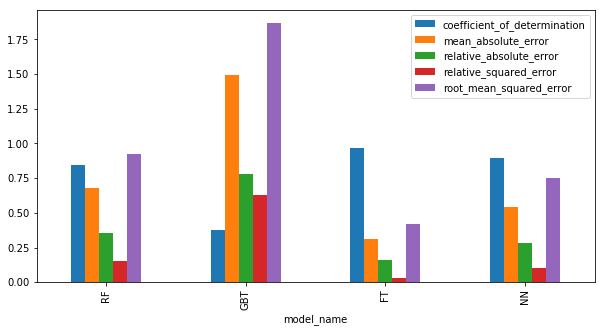

In [26]:
%matplotlib inline
summary.plot(kind="bar", figsize=(10, 5))

## Summary
In this template, you have seen how we can use revoscalepy and microsoftml to:
- read and store data on SQL server
- train and store machine learning models on SQL server 
- make fast, real-time prediction with the models 

This is part of our story of bringing intelligence to where the data live. Not only that this eliminates the need to move data between machines, it also allows us to leverage the computation power of the SQL server to do multithreading and parallel processing. Check out [this article](https://docs.microsoft.com/en-us/sql/advanced-analytics/getting-started-with-machine-learning-services) for more Microsoft's machine learning solutions with SQL platform. 

revoscalepy and microsoftml also have their R implementations ([RevoScaleR](https://docs.microsoft.com/en-us/machine-learning-server/r-reference/revoscaler/revoscaler) and [MicrosoftML](https://docs.microsoft.com/en-us/machine-learning-server/r-reference/microsoftml/microsoftml-package)), so you can do your work with whichever language you prefer without being restricted by the size of the dataset and limited memory of your client computer. 